In [16]:
%load_ext autoreload
%autoreload 2

# if you need to install Pybullet:
#   pip3 install Pybullet   (python3)
#   pip install PyBullet    (python2.x)

# let's start with imports
import numpy as np
from numpy.random import seed
from numpy.random import rand
import pybullet as p

from engine import *
from matplotlib import pyplot as plt

# seed random number generator
seed(1)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# create a pybullet engine from the engine module
engine = PyBulletEnvironment(gui=False)


In [18]:
#load shovel
startPos = [0,0,0]
startOrientation = p.getQuaternionFromEuler([0,0,0])
robot_urdf = './urdf/shovel/shovelFlat.urdf'

# load the robot
engine.open_environment(robot_urdf, startPos, startOrientation)

In [19]:
# load pebbles

# get shovel_link position
shovelLinkState = p.getLinkState(engine.ID[1], 2)

# admissible init positions
minpos = np.asarray(shovelLinkState[0]) - 7*1e-1
maxpos = np.asarray(shovelLinkState[0]) + 7*1e-1

# number of pebbles
pebbleNum = 300

# scatter pebbles
for i in range (pebbleNum):
    
    # generate init pos
    startPos = minpos + (rand(3) * (maxpos - minpos))
    startPos[-1] = 0.2
    
    # set orientation
    startOrientation = p.getQuaternionFromEuler([0,0,0])
    
    # load pebble 
    engine.load_urdf('./urdf/pebbles/pebbles.urdf', startPos, startOrientation)    
    
# simulate
engine.simulate(0.5)

In [20]:
# here we control the shovel to move to a target position and orientation using velocity control
# the loop controls the velocity of the joint until the target position is reached

# in the next params we define the control mode, the max force on the joint, the target position and velocity

# get the current end effector position
endEffectorPos = p.getLinkState(engine.ID[1], 2)[0]
pathLength = 0.5
pathCurvature = 50
Nwaypoints = 15

# compute the waypoints and print them
waypoints = engine.get_waypoints(endEffectorPos, pathLength, pathCurvature, Nwaypoints)
engine.draw_path(waypoints)
print('Initial position: ' + str(endEffectorPos))
print('Waypoints:\n' + '\n'.join(str(waypoint) for waypoint in waypoints))


Initial position: (0.7, 0.0, 0.025)
Waypoints:
[0.7000000000000031, 0.0, 0.025]
[0.7357142826773574, 1.2755101494121845e-05, 0.025]
[0.7714285471331398, 5.1020399489232204e-05, 0.025]
[0.8071427751457985, 0.00011479587443830042, 0.025]
[0.8428569484937672, 0.00020408149381978546, 0.025]
[0.878571048955541, 0.00031887721208079256, 0.025]
[0.9142850583096404, 0.00045918297063707314, 0.025]
[0.9499989583346331, 0.0006249986979156574, 0.025]
[0.9857127308091533, 0.0008163243093193273, 0.025]
[1.0214263575118674, 0.0010331597072266163, 0.025]
[1.0571398202215487, 0.001275504780998915, 0.025]
[1.092853100717044, 0.0015433594070159984, 0.025]
[1.1285661807773033, 0.0018367234485907602, 0.025]
[1.164279042181346, 0.002155596756061584, 0.025]
[1.1999916667083368, 0.0024999791667355, 0.025]


In [29]:
engine.simulate(0.5)

In [21]:
# control mode    
engine.control_waypoints(waypoints)

End Effector position: (0.7000000000000022, 0.0, 0.025)
End Effector position: (0.7341469910684814, 2.697237411089133e-06, 0.025)
End Effector position: (0.7697950150130077, 1.256318495899244e-05, 0.025)
End Effector position: (0.8055063797964893, 3.3405422201408786e-05, 0.025)
End Effector position: (0.8412195573033222, 6.805017168368977e-05, 0.025)
End Effector position: (0.8769344895605075, 0.00011898589315737673, 0.025)
End Effector position: (0.9126485324010138, 0.00018790180895284043, 0.025)
End Effector position: (0.9480729502023997, 0.00029234299922378543, 0.025)
End Effector position: (0.97278171254656, -0.0005151525445468309, 0.025)
End Effector position: (1.0076272026691997, 0.02261330637653311, 0.025)
End Effector position: (1.0559460460588814, 0.01539308991762496, 0.025)
End Effector position: (1.0925244415418969, 0.01045858820003133, 0.025)
End Effector position: (1.1261118273423043, 0.008763451434976421, 0.025)
End Effector position: (1.1534413821935077, 0.00806503526635

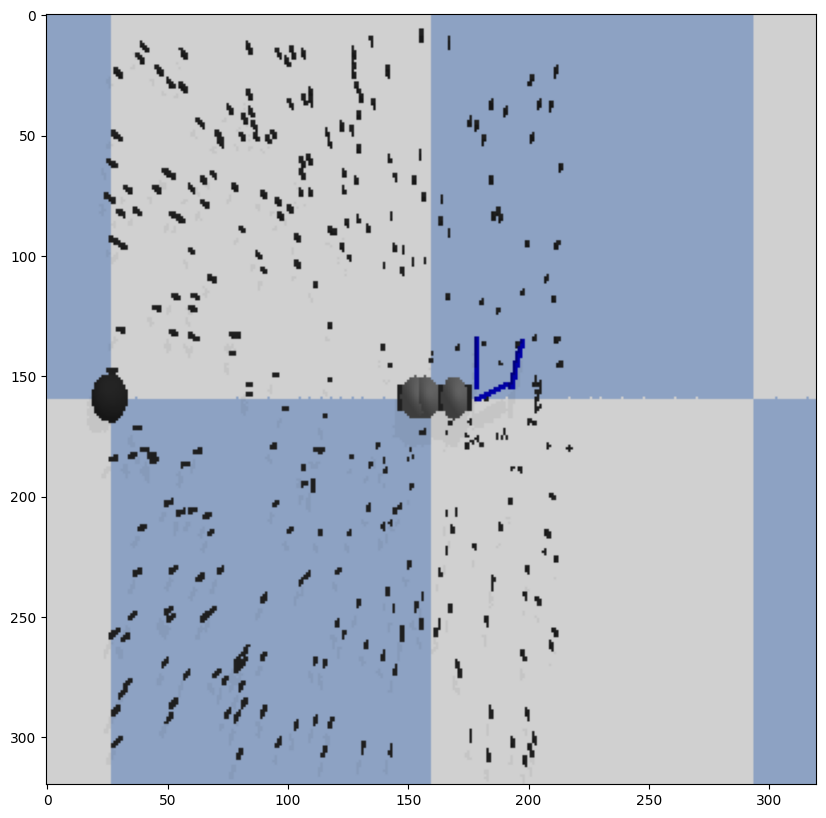

In [31]:
img = engine.get_top_view()
im = np.array(img[2])
im = im.reshape((img[0],img[1], 4))
plt.figure(figsize=(10,10))
plt.imshow(im[:,:, :3])